In [1]:
# imports
import numpy as np
import math
from scipy.spatial.distance import cdist

import sys as sys
import os
import tkinter as tk
from tkinter import filedialog

import matplotlib as mpl
import matplotlib.pyplot as plt
#import pylab as plb
import mpl_toolkits.mplot3d.axes3d as p3
import ipywidgets as widgets

from skimage import io
from scipy.signal import argrelextrema, savgol_filter
from scipy.optimize import curve_fit
from scipy import exp
from astropy import modeling
#import warnings
#from scipy.optimize import OptimizeWarning
import threading
from IPython.display import display, HTML
import time
import datetime as dt
import csv

#%matplotlib inline
%matplotlib widget

In [2]:
# options
zsave = True
zplot = True
zallplot = False # also plots all the correlation profiles and shows fits; useful for testing
zfixfreqscale = True # you can set the fixed frequency scale (used for plotting only) in the next cell
zinteractive = True # allows you to interactively remove ROIs in the frequency map that you think were assigned/fit incorrectly

In [3]:
# metadata
x_pixel_size = 0.116  # um
y_pixel_size = 0.116  # um
avg_delta_t = input('Enter average frame time (from other code) in msec: ') # ms - get this by running the appropriate code on the corresponding metadata!
try:
    avg_delta_t = float(avg_delta_t)
    print('average frame time: {0} msec'.format(avg_delta_t))
except ValueError:
    print('Please enter a valid number')

num_px_x = input('Enter size of image in x (width) in pixels: ') # pixels
try:
    num_px_x = int(num_px_x)
    print('width of image: {0} pixels'.format(num_px_x))
except ValueError:
    print('Please enter a valid number')
num_px_y = input('Enter size of image in y (height) in pixels: ') # pixels
try:
    num_px_y = int(num_px_y)
    print('height of image: {0} pixels'.format(num_px_y))
except ValueError:
    print('Please enter a valid number')

min_cycle_length = 2 #2 # frames
max_cycle_length = 50 # frames; must be less than or equal number used in Fiji script
#roi_size = 15 # pixels; must match that used in Fiji script
roi_size = input('Enter width/height of ROIs used to produce STICS map in FIJI in pixels: ') # pixels
try:
    roi_size = int(roi_size)
    print('ROI size: {0} pixels'.format(roi_size))
except ValueError:
    print('Please enter a valid number. Defaulting to 15.')
    roi_size = 15
    
correlation_threshold = 0.05 #0.02 #
min_freq = 0 #Hz
max_freq = 12 #Hz

Enter average frame time (from other code) in msec:  10


average frame time: 10.0 msec


Enter size of image in x (width) in pixels:  721


width of image: 721 pixels


Enter size of image in y (height) in pixels:  675


height of image: 675 pixels


Enter width/height of ROIs used to produce STICS map in FIJI in pixels:  25


ROI size: 25 pixels


In [4]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [5]:
root = tk.Tk()
root.withdraw()

directory = filedialog.askdirectory(title = 'choose folder with STICS data set format:.csv' ) 
os.chdir(directory)

In [6]:
# initialize
image_stack = np.empty(shape=(num_px_y,num_px_x))
#print(image_stack.shape)

period_map = np.zeros(shape=(num_px_y,num_px_x))
frequency_map = np.zeros(shape=(num_px_y,num_px_x))

centers_of_rois = []
frequency_list = []


In [7]:
def zslice_identifier(x):
    #print(x[-15:-10])
    return(x[-15:-10])
    #return(x[-1:-5]) #for Hetty movies

In [8]:
num_files = 0
all_files = os.listdir(directory)

for filename in sorted(all_files, key = zslice_identifier):
    
    if filename.endswith(".tif"):
        print(filename)
        num_files += 1
        temp_img = io.imread(filename)
        
        #imgplot = plt.imshow(temp_img)
        #plt.show()
        
        #check image properties
        image_size = temp_img.shape
        bit_depth = temp_img.dtype
        
        image_stack=np.dstack((image_stack, temp_img))
        
    #os.close(filename)
        
if num_files != max_cycle_length:
    print("Verify input metadata!")
    
print(image_stack.shape)

20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0000_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0001_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0002_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0003_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0004_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0005_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0006_t0000.tif
20200714 HNEC0262 control norm 14-7 40x video-120200714 HNEC0262 control norm 14-7 40x video-1_STICS_map_c00_z0007_t0000.tif


In [9]:
def find_nearest_two_val(array, value):
    array = np.asarray(array)
    idx = []
    
    idx.append((np.abs(array - value)).argmin())
    temp_array = np.empty_like(array)
    temp_array[:] = array
    temp_array[idx[0]] = 100000 #ignore this index
    idx.append((np.abs(temp_array - value)).argmin())
    round_num = 0
    test_val = (array[idx[0]]-value)*(array[idx[1]]-value)
    while test_val > 0:
        if round_num > 10:
            return idx[0]
        else:
            temp_array[idx[1]] = 100000 #ignore this index
            idx[1] = (np.abs(temp_array - value)).argmin()
            test_val = (array[idx[0]]-value)*(array[idx[1]]-value)
            round_num += 1
    return sorted(idx)

In [10]:
for i in range(0,num_px_x):
    for j in range(0,num_px_y):
        delta_t = []
        correlation = []
        for k in range(0,max_cycle_length):
            delta_t.append(k)
            correlation.append(image_stack[j,i,k])
            
            if k == max_cycle_length-1:
                
                delta_t = np.array(delta_t)
                correlation = np.array(correlation)
                
                correlation[np.isnan(correlation)] = 0
                correlation[np.isinf(correlation)] = 1
                #correlation[-np.isinf(correlation)] = -1
                
                #window length for savitzky-golay filter must be odd, so round up 1 if min_cycle_length is even
                if (min_cycle_length % 2) == 0:
                    window_length = min_cycle_length + 1
                else:
                    window_length = min_cycle_length
                
                #print(correlation)

                filt_correlation = savgol_filter(correlation, window_length, 1) #min_cycle_length defines window size, polynomial order 3
                
                if correlation[correlation > correlation_threshold].size > 3:
                    local_min_ind = argrelextrema(filt_correlation,np.less)[0]
                    #local_min_ind = local_min_ind[0]#[local_min_ind[0] > min_cycle_length] #ignore first few frames
                    local_max_ind = argrelextrema(filt_correlation,np.greater)
                    local_max_ind = local_max_ind[0][local_max_ind[0] > min_cycle_length] #ignore first few frames
                    local_max_ind = local_max_ind[local_max_ind > correlation_threshold] #ensure maxima are large enough
                    if len(local_max_ind) > 0:
                        approx_max_ind = local_max_ind[0] #delta_t[filt_correlation==np.amax(filt_correlation[local_max_ind])]
                        ind_of_ind = find_nearest_two_val(local_min_ind, approx_max_ind)

                        if type(ind_of_ind) != np.int64: #two valid minima found
                            minima_for_fit = [local_min_ind[ind_of_ind[0]]+1,local_min_ind[ind_of_ind[1]]-1]

                            if correlation[approx_max_ind] > correlation_threshold:
                                x = np.empty_like(delta_t[minima_for_fit[0]:minima_for_fit[1]])
                                x[:] = delta_t[minima_for_fit[0]:minima_for_fit[1]]
                                y = np.empty_like(correlation[minima_for_fit[0]:minima_for_fit[1]])
                                y[:] = correlation[minima_for_fit[0]:minima_for_fit[1]]

                                if len(x) > min_cycle_length: #proceed with fit only if sufficient temporal resolution

                                    #remove offset
                                    offset = y.min()
                                    y-=offset

                                    fitter = modeling.fitting.LevMarLSQFitter()
                                    initial_gaussian = modeling.models.Gaussian1D(amplitude= max(y), mean=approx_max_ind, stddev=min_cycle_length/2) #approx_max_ind-minima_for_fit[0])   # initial guess
                                    fitted_gaussian = fitter(initial_gaussian, x, y)
                                    #parameters are amplitude, mean, stddev
                                    #mean is cycle duration of one period in frames as it gives you the first peak after delta_t=0 (image correlated with itself) and hence how long it takes to look most like the original image again
                                    period = 0
                                    period = fitted_gaussian.parameters[1]

                                    frequency = 0;
                                    frequency = 1/(period*(avg_delta_t/1000)) # converted to Hz
                                    period_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = period
                                    frequency_map[j-round(roi_size/2):j+round(roi_size/2),i-round(roi_size/2):i+round(roi_size/2)] = frequency
                                    
                                    centers_of_rois.append((j,i))
                                    
                                    frequency_list.append(frequency)

                                    if zallplot == True:
                                        %matplotlib inline

                                        #plot of frequencies
                                        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

                                        ax.plot(delta_t, correlation, color='blue', linestyle='dashed',linewidth=2, markersize=12)   
                                        ax.plot(delta_t, filt_correlation, color='red', linestyle='dashed',linewidth=2, markersize=12)
                                        ax.plot(delta_t[minima_for_fit], filt_correlation[minima_for_fit], 'rx')
                                        ax.plot(delta_t[approx_max_ind], filt_correlation[approx_max_ind], 'bx')
                                        ax.plot(delta_t[local_min_ind], filt_correlation[local_min_ind], 'rd')
                                        ax.plot(delta_t[local_max_ind], filt_correlation[local_max_ind], 'bd')

                                        plot_x = np.linspace(x[0],x[-1], 200)
                                        ax.plot(plot_x, offset+fitted_gaussian(plot_x), color='black', linestyle='solid',linewidth=2, markersize=12)
                                        ax.plot(fitted_gaussian.parameters[1], 0, 'kx')

                                        ax.set_ylim(-1,1)
                                        ax.set_title("Correlation in ROI", fontsize=12)
                                        ax.set_ylabel("Correlation", fontsize=12)
                                        ax.set_xlabel("Time lag", fontsize=12)

                                        plt.tight_layout()


                                        # save fig
                                        if zsave == True:
                                            #script_dir = os.path.abspath('..') #os.path.dirname('..')
                                            results_dir = os.path.join(directory, 'Results/')
                                            file_name = 'Fitted_z-profile_correlation_{}_{}_{}.png'.format(i,j,dt.datetime.now().strftime('%Y%m%d%H%M%S'))
                                            if not os.path.isdir(results_dir):    
                                                os.makedirs(results_dir)
                                            plt.savefig(results_dir + file_name,dpi=130)
                                        plt.show()
                                        
                                        print("amplitude: " + str(fitted_gaussian.parameters[0]))
                                        print("mean: " + str(fitted_gaussian.parameters[1]))
                                        print("standard deviation: " + str(fitted_gaussian.parameters[2]))

                                        
%matplotlib widget

print('done fitting')

done fitting


In [43]:
# interactively remove outlier ROIs that do not match with your visual observations
if zinteractive == True:
    new_freq_map = np.empty_like(frequency_map)
    new_freq_map[:] = frequency_map
    
    new_freq_list = frequency_list[:]
    new_centers_of_rois = centers_of_rois[:]
    
    def closest_node(node, nodes):
        closest = nodes[cdist([node], nodes).argmin()]
        if cdist([node],[closest])[0] > roi_size:
            print('Unable to find close point. Try clicking more carefully')
            return
        return closest

    def define_roi(x,y):
        # find nearest ROI center to click
        clicked_point = (float(x),float(y))
        #closest_roi = find_roi(centers_of_rois, clicked_point)
        closest_roi = closest_node(clicked_point, centers_of_rois)
        #print(closest_roi)
        i = closest_roi[0]
        j = closest_roi[1]

        # find all surrounding x,y
        all_x = list(range((i-round(roi_size/2)),(i+round(roi_size/2))))
        all_y = list(range((j-round(roi_size/2)),(j+round(roi_size/2))))

        return [all_x, all_y], closest_roi

    def remove_freq(xs, ys, center):  
        #roi = define_roi(x, y)
        freq = frequency_map[center[0], center[1]]
        if freq == 0:
            print('No non-zero frequency to delete.')
            return
        #remove from frequency map
        for i in range(len(xs)):
            for j in range(len(ys)):
                #print(len(xs))
                #print(len(ys))
                #print(xs[i])
                #print(ys[j])
                new_freq_map[xs[i],ys[j]] = 0

        #remove from frequency list (removes first item with this value from the list, but the order doesn't matter for the list)
        new_freq_list.remove(freq)
        #remove from centers of rois
        new_centers_of_rois.remove(center)
    
    def onclick(event):
        if event.inaxes is not None and not hasattr(event, 'already_picked'):
            ax = event.inaxes

            remove = [artist for artist in pickable_artists if artist.contains(event)[0]]

            if not remove:
                # add a pt
                x, y = ax.transData.inverted().transform_point([event.x, event.y])
                pt, = ax.plot(x, y, 'o', picker=5)
                pickable_artists.append(pt)
            else:
                for artist in remove:
                    artist.remove()
            plt.draw()
            return rois, freqs

    

In [44]:
# plot frequency map
if zplot == True: 
    if zinteractive == True:
        %matplotlib widget
    if zinteractive == False:
        %matplotlib inline
    
    #plot of frequencies
    img_height = 10
    img_width = img_height*num_px_y/num_px_x
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(img_height, img_width))
        
    if zfixfreqscale == False:
        color_lim = (np.nanmin(frequency_map),np.nanmax(frequency_map))
    else:
        color_lim = (min_freq,max_freq)
    if zinteractive == True:
        #im = ax.imshow(frequency_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]),  picker=True)
        im = ax.imshow(frequency_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]), animated = True)
    else:
        im = ax.imshow(frequency_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
    if zinteractive == True:
        ax.set_title("Frequencies across image [Hz] \nClick to assign erroneous frequencies to be removed \nClick again to not remove it", fontsize=12)
    else:    
        ax.set_title("Frequencies across image [Hz]", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlabel("x", fontsize=12)
    pcm = ax.pcolormesh(frequency_map,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
    fig.colorbar(pcm, ax=ax)

    #plt.tight_layout()
    
    if zinteractive == True:
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        pickable_artists = []
        pt, = ax.plot(0.5, 0.5, 'o')  # 5 points tolerance
        pickable_artists.append(pt)
        
    # save fig
    if zsave == True:
        #script_dir = os.path.abspath('..') #os.path.dirname('..')
        results_dir = os.path.join(directory, 'Results/')
        file_name = 'Frequency_map_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
        if not os.path.isdir(results_dir):    
            os.makedirs(results_dir)
        plt.savefig(results_dir + file_name,dpi=130)    
        
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
# disconnect interactivity
if zinteractive == True:
    fig.canvas.mpl_disconnect(cid)
    print('Disconnected interactivity. Your changes can be seen by running the next two cells. If you are not satisfied with them, you will have the option to undo them after the plot.')

Disconnected interactivity. Your changes can be seen by running the next two cells. If you are not satisfied with them, you will have the option to undo them after the plot.


In [46]:
rois = []
freqs = []
for i in range (1,len(pickable_artists)):
    ydata,xdata = pickable_artists[i].get_data()
    roi, center = define_roi(xdata, ydata)
    rois.append(roi)
    freqs.append(frequency_map[center[0],center[1]])
    print('Removing frequency data (' + str(frequency_map[center[0],center[1]]) + 'Hz) from ROI at: x = ' + str(center[1]) + ', y = ' + str(center[0]))
    remove_freq(roi[0], roi[1], center)
    #print(roi[0])


Removing frequency data (11.838953787657426Hz) from ROI at: x = 538, y = 213
Removing frequency data (11.809557028337775Hz) from ROI at: x = 588, y = 313


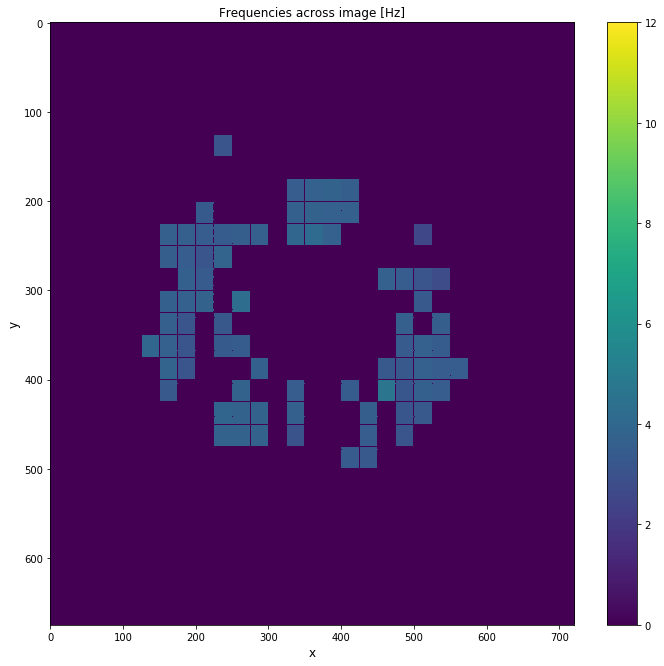

In [47]:
if zplot == True and zinteractive == True: 

    %matplotlib inline
    
    #plot of frequencies
    img_height = 10
    img_width = img_height*num_px_y/num_px_x
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(img_height, img_width))
        
    if zfixfreqscale == False:
        color_lim = (np.nanmin(new_freq_map),np.nanmax(new_freq_map))
    else:
        color_lim = (min_freq,max_freq)

    im = ax.imshow(new_freq_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
    ax.set_title("Frequencies across image [Hz]", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlabel("x", fontsize=12)
    pcm = ax.pcolormesh(new_freq_map,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
    fig.colorbar(pcm, ax=ax)

    plt.tight_layout()
        
    # save fig
    if zsave == True:
        #script_dir = os.path.abspath('..') #os.path.dirname('..')
        results_dir = os.path.join(directory, 'Results/')
        file_name = 'Frequency_map_edited{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
        if not os.path.isdir(results_dir):    
            os.makedirs(results_dir)
        plt.savefig(results_dir + file_name,dpi=130)    
        
    plt.show()

In [48]:
if zinteractive == True:
    def yes_no(question):
        reply = str(input(question+' (y/n): ')).lower().strip()
        try:
            if reply[0] == 'y':
                return True
            elif reply[0] == 'n':
                return False
            else:
                print('Invalid Input')
                return yes_no(question)
        except Exception as error:
            print("Please enter a valid input")
            print(error)
            return yes_no(question)
    
    answer = yes_no('Do you want to undo all frequency deletions?')
    if answer == True:
        new_freq_map[:] = frequency_map
        new_freq_list = frequency_list[:]
        new_centers_of_rois = centers_of_rois[:]
        print('Run above cells again if you wish to choose other frequencies to delete')
    elif answer == False:
        #frequency_map[:] = new_freq_map
        #frequency_list = new_freq_list[:]
        #centers_of_rois = new_centers_of_rois[:]
        print('Saved changes to frequency map')
   

Do you want to undo all frequency deletions? (y/n):  n


Saved changes to frequency map


In [49]:
if zsave == True:
    save_freq = np.asarray(frequency_list)
    
    results_dir = os.path.join(directory, 'Results/')
    #file_name = 'Frequency_list_{}.csv'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    file_name = 'Frequency_list.csv'
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    
    np.savetxt(results_dir + file_name, save_freq, delimiter=',', newline='\n', fmt='%f')

print('done')

done


done


In [10]:
def gaussian(x, offset, amp, x0, sigma):
#def gaussian(x, amp, x0, sigma):
    return offset + amp * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    #return amp * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gaussian_fit(x, y, correlation_threshold, min_cycle_length):
    #mean = sum(x * y) / sum(y)
    #sig = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    
    n = x.size #len(x)
    mean = (x[-1]-x[0])/2 #sum(x*y)/n
    sig = (x[-1]-x[0])/2 #math.sqrt(sum((x-mean)**2)/(n-1))
    #sig = sum(y*(x-mean)**2)/n
    
    print("estimated offset: " + str(np.amin(y)))
    min_offset = np.amin(y)-1
    print("offset min: " + str(min_offset))
    max_offset = np.amin(y) + (np.amax(y)-np.amin(y))/2
    print("offset max: " + str(max_offset))
    print("estimated amplitude: " + str(np.amax(y)))
    min_amp = np.amin(y)+correlation_threshold
    print("amplitude min: " + str(min_amp))
    max_amp = 1 #np.amax(y)
    print("amplitude max: " + str(max_amp))
    print("estimated mean: " + str(mean))
    min_mean = x[0]
    print("mean min: " + str(min_mean))
    max_mean = x[-1]
    print("mean max: " + str(max_mean))
    print("estimated sigma: " + str(sig))
    min_sig = mean/10 #min_cycle_length/4
    print("sigma min: " + str(min_sig))
    max_sig = (x[-1]-x[0])
    print("sigma max: " + str(max_sig))
    
    with warnings.catch_warnings():
        warnings.simplefilter("error", ValueError) #OptimizeWarning)
        try:
            popt, pcov = curve_fit(gaussian, x, y, p0=[min(y), max(y), mean, sig])
            #popt, pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sig]) #, bounds = ((min_amp,0,min_sig), (max_amp,np.inf,max_sig)))
            #popt, pcov = curve_fit(gaussian, x, y, p0=[min(y), max(y), mean, sig], bounds = ((min_offset,min_amp,0,min_sig), (max_offset,max_amp,np.inf,max_sig)))

            return popt
        #except OptimizeWarning:
            #return "Could not fit Gaussian"
        except ValueError:
            return "Could not fit Gaussian"

In [ ]:
#        def on_press(event):
#            with out:
#                print('Removing data from ROI at: x = ' + str(event.xdata) + ', y = ' + str(event.ydata))
#                remove_freq(event.x, event.y)
#                cid = fig.canvas.mpl_connect('button_press_event', on_press)
#                im.set_data(frequency_map)
#                fig.canvas.draw()
#                fig.canvas.flush_events()
#            display(out)
#            #return

    def on_pick(event):
        artist = event.artist
        if isinstance(artist, AxesImage):
            im = artist
            A = im.get_array()
            print('Pick image', A.shape)
            
#    def onclick(event):
#        if event.xdata != None and event.ydata != None:
#            print(event.xdata, event.ydata)
class RemoveFrequencies:

    def __init__(self, im, out):
        #self.line = line
        self.roi = [] #define_roi(click_x, click_y)
        self.freq = [] #frequency_map(click_x, click_y)
#            if freq == 0:
#                print('No non-zero frequency to delete.')
#                return
#            #remove from frequency map
#            frequency_map[roi[0],roi[1]] = 0

#            #remove from frequency list (removes first item with this value from the list, but the order doesn't matter for the list)
#            frequency_list.remove(freq)
        self.cid = fig.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event, out):
        print('click', event)
        self.roi = define_roi(event.x, event.y)
        self.freq = frequency_map(event.x, event.y)
        out.append_stdout('Removing data from ROI at: x = ' + str(event.xdata) + ', y = ' + str(event.ydata))
        if freq == 0:
            out.append_stdout('No non-zero frequency to delete.')
        #remove from frequency map
        frequency_map[roi[0],roi[1]] = 0

        #remove from frequency list (removes first item with this value from the list, but the order doesn't matter for the list)
        frequency_list.remove(freq)
        #if event.inaxes!=self.line.axes: return
        #self.xs.append(event.xdata)
        #self.ys.append(event.ydata)
        self.im.set_data(frequency_map)
        self.figure.canvas.draw()

In [16]:
import threading
from IPython.display import display, HTML
import ipywidgets as widgets
import time

def thread_func(something, out):
    for i in range(1, 5):
        time.sleep(0.3)
        out.append_stdout('{} {} {}\n'.format(i, '**'*i, something))
    out.append_display_data(HTML("<em>All done!</em>"))

display('Display in main thread')
out = widgets.Output()
# Now the key: the container is displayed (while empty) in the main thread
display(out)

thread = threading.Thread(
    target=thread_func,
    args=("some text", out))
thread.start()

out.clear_output()

'Display in main thread'

Output()

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

pickable_artists = []
pt, = ax.plot(0.5, 0.5, 'o')  # 5 points tolerance
pickable_artists.append(pt)


def onclick(event):
    if event.inaxes is not None and not hasattr(event, 'already_picked'):
        ax = event.inaxes

        remove = [artist for artist in pickable_artists if artist.contains(event)[0]]

        if not remove:
            # add a pt
            x, y = ax.transData.inverted().transform_point([event.x, event.y])
            pt, = ax.plot(x, y, 'o', picker=5)
            pickable_artists.append(pt)
        else:
            for artist in remove:
                artist.remove()
        plt.draw()


fig.canvas.mpl_connect('button_release_event', onclick)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([0], [0])  # empty line
linebuilder = LineBuilder(line)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt


class DrawDragPoints(object):
    """
    Demonstrates a basic example of the "scaffolding" you need to efficiently
    blit drawable/draggable/deleteable artists on top of a background.
    """
    def __init__(self):
        self.fig, self.ax = self.setup_axes()
        self.xy = []
        self.tolerance = 10
        self._num_clicks = 0

        # The artist we'll be modifying...
        self.points = self.ax.scatter([], [], s=200, color='red',
                                      picker=self.tolerance, animated=True)

        connect = self.fig.canvas.mpl_connect
        connect('button_press_event', self.on_click)
        self.draw_cid = connect('draw_event', self.grab_background)

    def setup_axes(self):
        """Setup the figure/axes and plot any background artists."""
        fig, ax = plt.subplots()

        # imshow would be _much_ faster in this case, but let's deliberately
        # use something slow...
        ax.imshow(np.random.random((1000, 1000)), cmap='gray')

        ax.set_title('Left click to add/drag a point\nRight-click to delete')
        return fig, ax

    def on_click(self, event):
        """Decide whether to add, delete, or drag a point."""
        # If we're using a tool on the toolbar, don't add/draw a point...
        if self.fig.canvas.toolbar._active is not None:
            return

        contains, info = self.points.contains(event)
        if contains:
            i = info['ind'][0]
            if event.button == 1:
                self.start_drag(i)
            elif event.button == 3:
                self.delete_point(i)
        else:
            self.add_point(event)

    def update(self):
        """Update the artist for any changes to self.xy."""
        self.points.set_offsets(self.xy)
        self.blit()

    def add_point(self, event):
        self.xy.append([event.xdata, event.ydata])
        self.update()

    def delete_point(self, i):
        self.xy.pop(i)
        self.update()

    def start_drag(self, i):
        """Bind mouse motion to updating a particular point."""
        self.drag_i = i
        connect = self.fig.canvas.mpl_connect
        cid1 = connect('motion_notify_event', self.drag_update)
        cid2 = connect('button_release_event', self.end_drag)
        self.drag_cids = [cid1, cid2]

    def drag_update(self, event):
        """Update a point that's being moved interactively."""
        self.xy[self.drag_i] = [event.xdata, event.ydata]
        self.update()

    def end_drag(self, event):
        """End the binding of mouse motion to a particular point."""
        for cid in self.drag_cids:
            self.fig.canvas.mpl_disconnect(cid)

    def safe_draw(self):
        """Temporarily disconnect the draw_event callback to avoid recursion"""
        canvas = self.fig.canvas
        canvas.mpl_disconnect(self.draw_cid)
        canvas.draw()
        self.draw_cid = canvas.mpl_connect('draw_event', self.grab_background)

    def grab_background(self, event=None):
        """
        When the figure is resized, hide the points, draw everything,
        and update the background.
        """
        self.points.set_visible(False)
        self.safe_draw()

        # With most backends (e.g. TkAgg), we could grab (and refresh, in
        # self.blit) self.ax.bbox instead of self.fig.bbox, but Qt4Agg, and
        # some others, requires us to update the _full_ canvas, instead.
        self.background = self.fig.canvas.copy_from_bbox(self.fig.bbox)

        self.points.set_visible(True)
        self.blit()

    def blit(self):
        """
        Efficiently update the figure, without needing to redraw the
        "background" artists.
        """
        self.fig.canvas.restore_region(self.background)
        self.ax.draw_artist(self.points)
        self.fig.canvas.blit(self.fig.bbox)

    def show(self):
        plt.show()

DrawDragPoints().show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …